<a href="https://www.kaggle.com/code/mennatullaheisawy/weather-forecasting-time-series-analysis-lstm?scriptVersionId=191803957" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


2024-08-09 15:16:03.402390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 15:16:03.402529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 15:16:03.553471: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading and Exploration

In [2]:
df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [4]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [6]:
df = df.set_index('date')
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


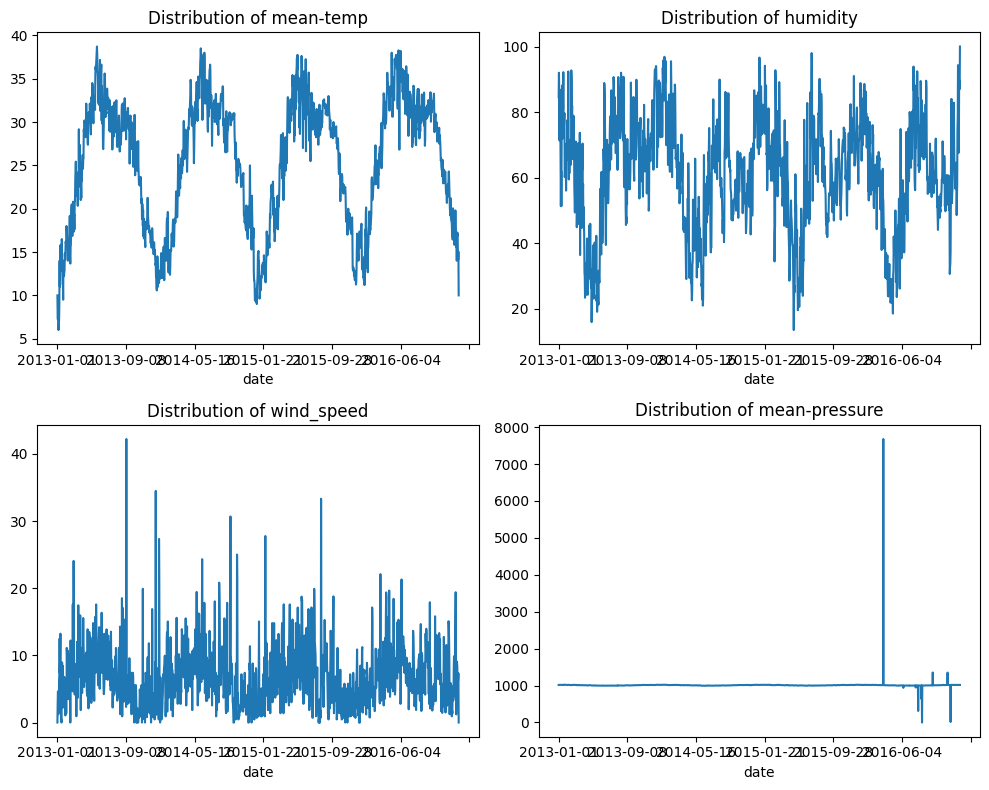

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
df['meantemp'].plot()
plt.title('Distribution of mean-temp')

plt.subplot(2, 2, 2)
df['humidity'].plot()
plt.title('Distribution of humidity')

plt.subplot(2, 2, 3)
df['wind_speed'].plot()
plt.title('Distribution of wind_speed')

plt.subplot(2, 2, 4)
df['meanpressure'].plot()
plt.title('Distribution of mean-pressure')

plt.tight_layout()
plt.show()

# Data Prepration and Splitting

## 1. Forecasting Mean Temprature 

In [53]:
train_size = int(0.8* len(data))
test_size = len(data) - train_size
def train_test(data):
    # the train size will be the first 80% rows of the total rows and the test will be the rest
    train_size = int(0.8* len(data))
    test_size = len(data) - train_size

    # time_step is as same as batch_size
    time_step = 30
    train_data = data[0:train_size, :]
    test_data = data[train_size - time_step :, :]

    # preparing the training data
    X_train, y_train = [], []
    for i in range(30, len(train_data)):
        X_train.append(data[i- time_step:i, :] )
        y_train.append(data[i, :])
    X_train = np.array(X_train)
    y_train = np.array(y_train)


    # preparing the test data
    X_test, y_test = [], []
    for i in range(30, len(test_data)):
        X_test.append(test_data[i- time_step:i, :] )
        y_test.append(test_data[i, :])
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test

In [9]:
data = df[['meantemp']].values
X_train, X_test, y_train, y_test = train_test(data)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1139, 30, 1) (1139, 1)
(293, 30, 1) (293, 1)


In [10]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_test.shape[1], X_test.shape[2])),
    GRU(32),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
call_back = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=call_back)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 490.6836 - val_loss: 427.3538
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 286.4745 - val_loss: 338.5952
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 206.2490 - val_loss: 269.9997
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 162.0509 - val_loss: 216.3335
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 124.5701 - val_loss: 174.3944
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 103.9575 - val_loss: 142.2455
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 84.7688 - val_loss: 117.2493
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 75.4917 - val_loss: 98.7564
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 65.3095 - val_loss: 85.2384
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 60.7523 - val_loss: 75.2900
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 57.4954 - val_loss: 68.5116
Epoch 12/100
72/7

In [12]:
mean_temp_preds = model.predict(X_test)
mean_temp_preds_df = pd.DataFrame(data={'Actuals':y_test.flatten() , 'Predictions':mean_temp_preds.flatten()})
mean_temp_preds_df.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


,Actuals,Predictions
0,24.066667,23.161196
1,23.937500,24.587339
2,26.312500,24.079729
3,26.187500,26.243208
4,26.785714,25.933863


## 2. Forecasting Humadity

In [47]:
data = df[['humidity']].values
X_train, X_test, y_train, y_test = train_test(data)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1139, 30, 1) (1139, 1)
(293, 30, 1) (293, 1)


In [48]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_test.shape[1], X_test.shape[2])),
    GRU(32),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

call_back = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=call_back)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 3852.4680 - val_loss: 2665.2380
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3075.8257 - val_loss: 2413.9619
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2827.9739 - val_loss: 2196.0803
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2595.1509 - val_loss: 2000.1736
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2367.7644 - val_loss: 1820.2968
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2196.7798 - val_loss: 1656.2050
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1998.1354 - val_loss: 1505.6833
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1859.3530 - val_loss: 1367.6429
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1627.2981 - val_loss: 1242.1375
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1551.8547 - val_loss: 1127.0442
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1382.2283 - val_loss: 1022.004

In [49]:
hum_temp_preds = model.predict(X_test)
hum_temp_preds_df = pd.DataFrame(data={'Actuals':y_test.flatten() , 'Predictions':hum_temp_preds.flatten()})
hum_temp_preds_df.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


,Actuals,Predictions
0,58.933333,56.237728
1,53.750000,56.237732
2,50.312500,56.237732
3,61.250000,56.237728
4,61.857143,56.237732


## 3. Forecasting Wind_Speed

In [22]:
data = df[['wind_speed']].values
X_train, X_test, y_train, y_test = train_test(data)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1139, 30, 1) (1139, 1)
(293, 30, 1) (293, 1)


In [24]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_test.shape[1], X_test.shape[2])),
    GRU(64),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

call_back = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=call_back)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 27.5567 - val_loss: 14.0439
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 22.9757 - val_loss: 13.2181
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 16.7703 - val_loss: 12.9506
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 15.5946 - val_loss: 12.6138
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 16.2788 - val_loss: 14.3281
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 16.6154 - val_loss: 12.9967
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 16.9688 - val_loss: 12.9010
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 20.5504 - val_loss: 12.7737
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 15.0571 - val_loss: 12.9865


In [25]:
wind_temp_preds = model.predict(X_test)
wind_temp_preds_df = pd.DataFrame(data={'Actuals':y_test.flatten() , 'Predictions':wind_temp_preds.flatten()})
wind_temp_preds_df.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


,Actuals,Predictions
0,8.646667,6.990073
1,10.881250,8.167861
2,6.843750,8.841696
3,6.712500,7.078467
4,3.578571,7.410934


## 4. Forecasting Mean-Pressure

In [26]:
data = df[['meanpressure']].values
X_train, X_test, y_train, y_test = train_test(data)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1139, 30, 1) (1139, 1)
(293, 30, 1) (293, 1)


In [27]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_test.shape[1], X_test.shape[2])),
    GRU(32),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

call_back = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=call_back)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1011179.8750 - val_loss: 1185171.1250
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 997456.8750 - val_loss: 1179144.8750
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 991567.0625 - val_loss: 1173888.7500
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 987423.5000 - val_loss: 1168823.7500
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 982114.5000 - val_loss: 1163861.2500
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 976760.2500 - val_loss: 1158966.8750
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 972402.5000 - val_loss: 1154122.0000
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 967551.3125 - val_loss: 1149318.2500
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 962395.6250 - val_loss: 1144548.3750
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 959072.5625 - val_loss: 1139807.2500
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
pressure_temp_preds = model.predict(X_test)
pressure_temp_preds_df = pd.DataFrame(data={'Actuals':y_test.flatten() , 'Predictions':pressure_temp_preds.flatten()})
pressure_temp_preds_df.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


,Actuals,Predictions
0,1014.866667,239.155167
1,1012.812500,239.155167
2,1010.437500,239.155167
3,1009.812500,239.155167
4,1009.214286,239.155167


# Model Predictions Visualization

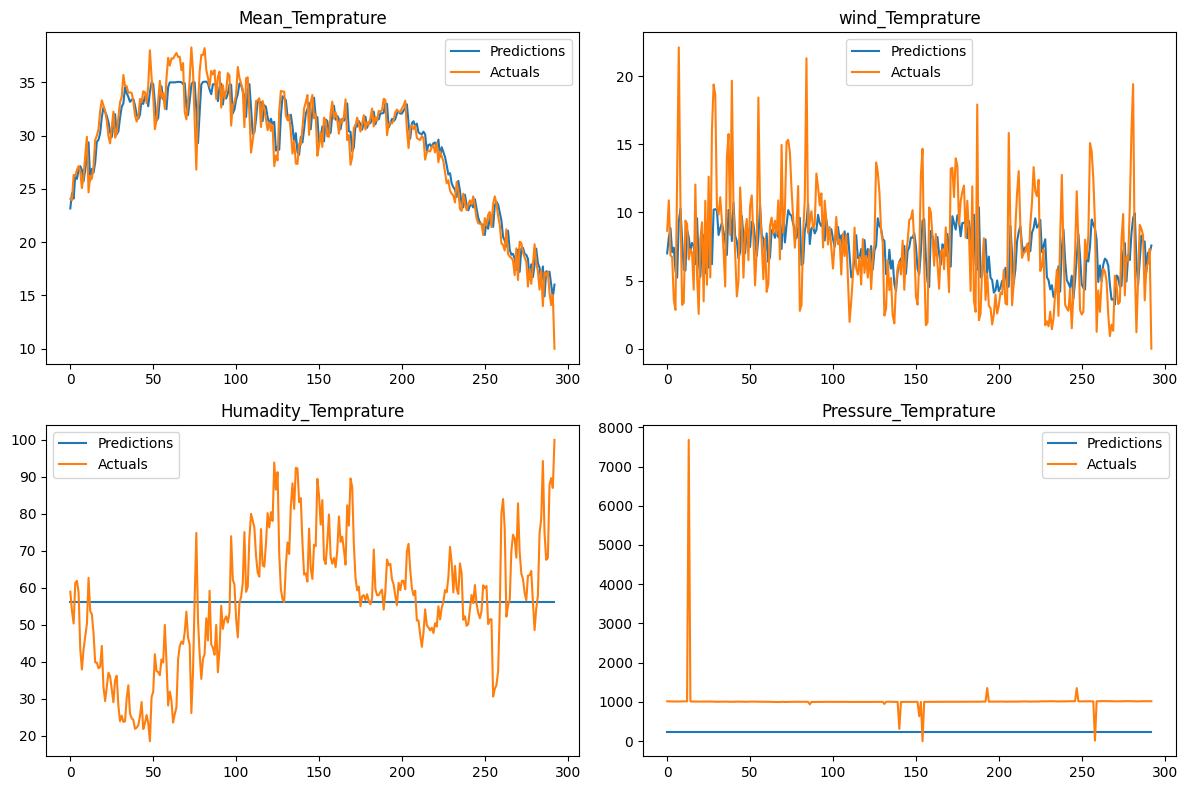

In [71]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
df = mean_temp_preds_df
plt.plot(df['Predictions'])
plt.plot(df['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.title('Mean_Temprature')

plt.subplot(2,2,2)
df = wind_temp_preds_df
plt.plot(df['Predictions'])
plt.plot(df['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.title('wind_Temprature')

plt.subplot(2,2,3)
df = hum_temp_preds_df
plt.plot(df['Predictions'])
plt.plot(df['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.title('Humadity_Temprature')

plt.subplot(2,2,4)
df = pressure_temp_preds_df
plt.plot(df['Predictions'])
plt.plot(df['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.title('Pressure_Temprature')

plt.tight_layout()
plt.show()